# Fine Tuning
Using the dataset with only the first frames from burst images under the assumption that of the bursts the first frame is the most likely to not be empty,
further training current model to increase performance. Using the same seed for randomsplitter for the train/validation split to hopefully avoid data-bleed.

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image
from fastai.vision.all import *
frame1_labels=pd.read_csv('frame1_labels.csv')

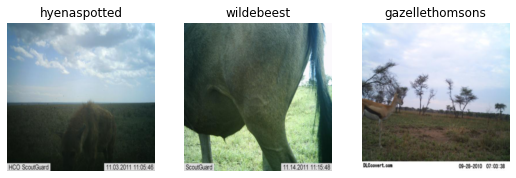

In [2]:
def get_x(r): return r['image_id']
def get_y(r): return r['species']
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=RandomSplitter(seed=42),
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = Resize(256, ResizeMethod.Squish))

dls = dblock.dataloaders(frame1_labels,bs=16)
dls.show_batch(nrows=1,ncols=3)

In [3]:
fscore = FBeta(average='macro', beta=1)
learn = cnn_learner(dls, resnet50, metrics=[accuracy, fscore, error_rate])

In [5]:
learn.load('stage_3_try_2')

In [6]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.9054607491852948e-06)

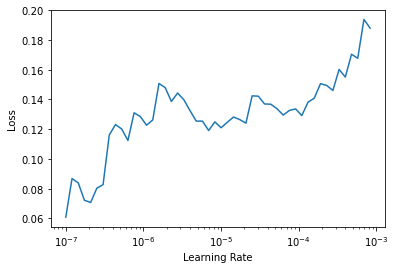

In [8]:
learn.lr_find()

In [9]:
learn.fit_one_cycle(5,lr_max=slice(6.3e-8,1.9e-6),cbs=[SaveModelCallback(monitor='valid_loss',
                                                                      every_epoch=True,
                                                                      fname='fine_tune')])

epoch,train_loss,valid_loss,accuracy,fbeta_score,error_rate,time
0,0.164199,0.144201,0.946726,0.798222,0.053274,40:56
1,0.164156,0.141589,0.946560,0.790113,0.053440,39:57
2,0.161067,0.141716,0.945392,0.799308,0.054608,39:58
3,0.181749,0.142954,0.945059,0.795665,0.054941,39:58
4,0.188360,0.140718,0.945948,0.797649,0.054052,39:57


Training with this variation of the dataset seems to have improve the model's validation loss and f1score. Validation loss is halved with f1 score increasing by nearly 0.1. I also attempted training from Resnet50 using this version of the dataset and the f1 score stayed below 0.6 for all epochs. Thus far this version of the model has the best performance.

In [10]:
learn.save('fine_tuned_model')

Path('models/fine_tuned_model.pth')

In [4]:
learn.load('fine_tuned_model')

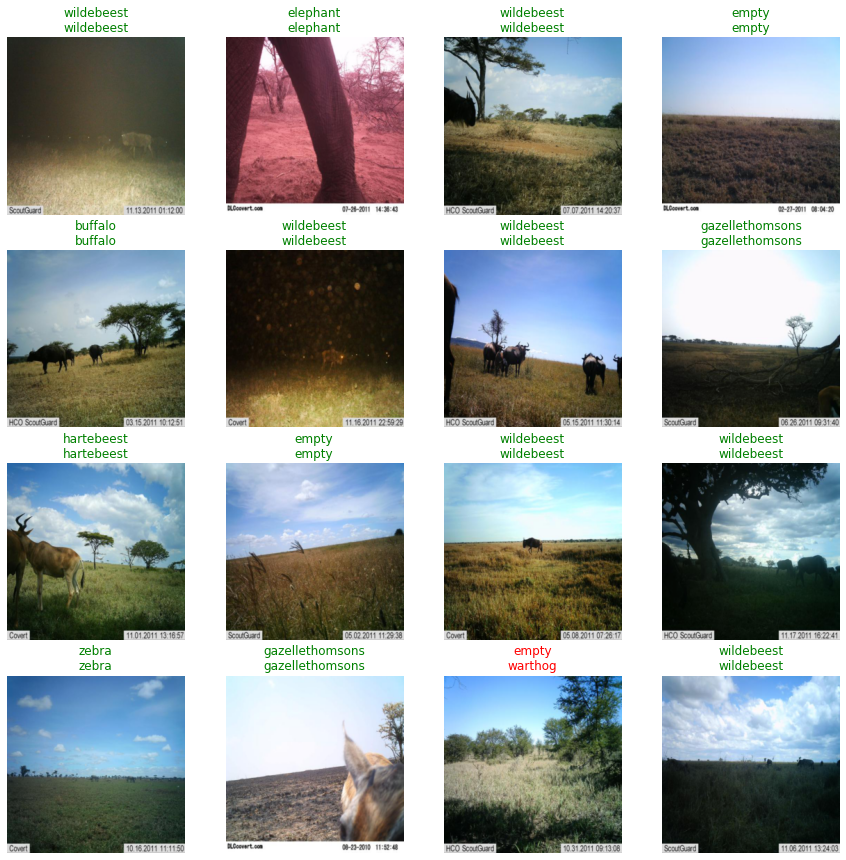

In [13]:
learn.show_results(max_n=25,figsize=(15,15))
plt.savefig('fined_tuned_validation_sample.png')

In [5]:
#Code from fastai forums to fix memory efficency issue with interpretation
class Interpretation():
    "Interpretation base class, can be inherited for task specific Interpretation classes"
    def __init__(self, dl, preds, targs, decoded, losses): store_attr()

    def __getitem__(self, idxs):
        "Get the the inputs, preds, targs, decoded outputs, and losses at `idxs`"
        if isinstance(idxs, Tensor): idxs = idxs.tolist()
        if not is_listy(idxs): idxs = [idxs]
        attrs = 'preds,targs,decoded,losses'
        res = L([getattr(self, attr)[idxs] for attr in attrs.split(',')])
        inps = [self.dl.do_item(o)[:self.dl.n_inp] for o in idxs]
        inps = self.dl.after_batch(to_device(self.dl.do_batch(inps), self.dl.device))
        return inps + res

    @classmethod
    def from_learner(cls, learn, ds_idx=1, dl=None, act=None):
        "Construct interpretation object from a learner"
        if dl is None: dl = learn.dls[ds_idx]
        return cls(dl, *learn.get_preds(dl=dl, with_input=False, with_loss=True, with_decoded=True, act=None))

    def top_losses(self, k=None, largest=True):
        "`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`)."
        return self.losses.topk(ifnone(k, len(self.losses)), largest=largest)

    def plot_top_losses(self, k, largest=True, **kwargs):
        losses,idx = self.top_losses(k, largest)
        inps, preds, targs, decoded, _ = self[idx]
        if not isinstance(inps, tuple): inps = (inps,)
        b = inps + (targs,)
        x,y,its = self.dl._pre_show_batch(b, max_n=k)
        b_out = inps + (decoded,)
        x1,y1,outs = self.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), preds, losses,  **kwargs)

In [6]:
interp = Interpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(dls.valid_ds)==len(losses)==len(idxs)

True

This has not eliminated the issue of mislabeling in the dataset, however it has reduced loss.
It would be ideal to relabel incorrectly images in the dataset, however due to the size of the dataset I have not found a time efficient way to do about doing this as of yet. 

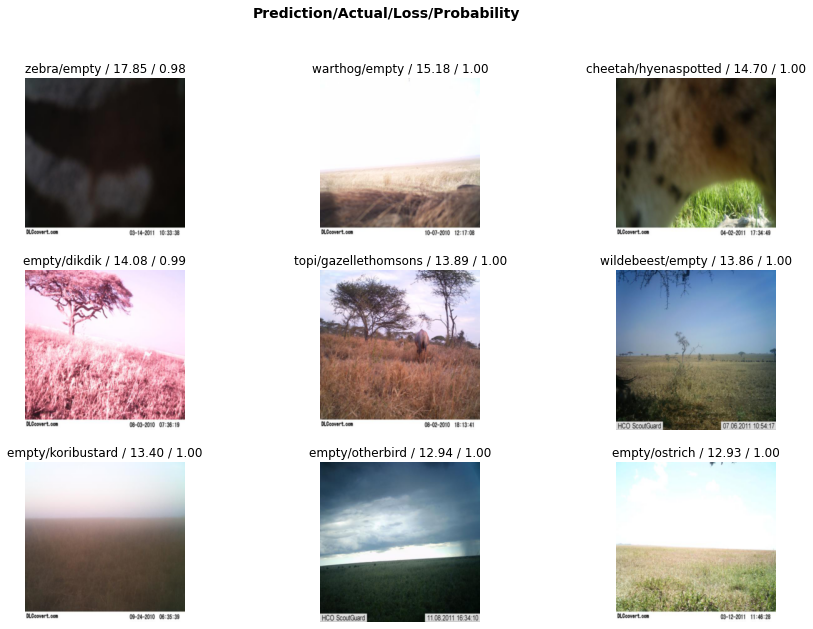

In [7]:
interp.plot_top_losses(9, figsize=(15,10))
plt.savefig('fine_tune_top_losses.png')

# Testing against Test set image

In [27]:
learn.export(fname='fine_tuned_model.pkl')

In [5]:
path=Path()
path.ls(file_exts='.pkl')

(#2) [Path('export1.pkl'),Path('fine_tuned_model.pkl')]

In [29]:
learn_inf = load_learner(path/'fine_tuned_model.pkl')

In [31]:
learn_inf.predict('S4/B10/B10_R1/S4_B10_R1_IMAG0409.JPG')

('giraffe',
 tensor(16),
 tensor([1.3073e-07, 3.2512e-07, 2.0503e-07, 1.2751e-07, 4.5758e-07, 4.6293e-08,
         8.8093e-08, 3.3254e-07, 5.1756e-08, 6.1501e-08, 1.5675e-07, 1.3866e-06,
         2.3552e-05, 5.6251e-08, 4.5717e-07, 6.5789e-08, 9.9957e-01, 1.4639e-06,
         1.6180e-07, 2.2113e-06, 1.3265e-07, 8.3990e-08, 1.2072e-07, 2.1906e-07,
         5.0719e-08, 5.8427e-08, 2.0344e-07, 4.2774e-08, 3.8113e-08, 8.0533e-09,
         2.8946e-08, 5.4350e-09, 1.3210e-07, 1.6761e-05, 8.6156e-08, 1.4793e-08,
         2.2058e-08, 4.3831e-08, 8.1587e-08, 3.1749e-09, 6.5166e-08, 1.0229e-07,
         9.1905e-07, 4.4277e-08, 3.3870e-08, 2.9428e-04, 8.5299e-05, 5.2352e-08]))

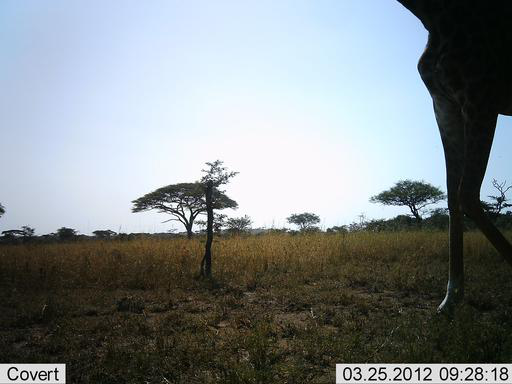

In [32]:
#Image being labeled
im=Image.open('S4/B10/B10_R1/S4_B10_R1_IMAG0409.JPG','r')
im

In [33]:
#test csv has information and labels for test images
#species label matches!
test=pd.read_csv('test.csv')
test.loc[test['image_id'] == 'S4/B10/B10_R1/S4_B10_R1_IMAG0409.JPG']

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,category_id,species,season,datetime,count,image_id
433158,433158,13,giraffe,S4,2012-03-25 09:28:27,1,S4/B10/B10_R1/S4_B10_R1_IMAG0409.JPG
